# Explore Learning Curves for a Simple BERT Model - 6 Layers, 1e-1 reg - with Frozen Embeddings on the IMDB Dataset
This notebook explores how to determine the size of a dataset using learning curves. Each incremental dataset is subsampled (with repetition) until it has 20,000 samples.

## Set-up

In [ ]:
!pip install -q datasets transformers

     |████████████████████████████████| 431 kB 14.2 MB/s 
     |████████████████████████████████| 4.9 MB 59.7 MB/s 
     |████████████████████████████████| 115 kB 67.9 MB/s 
     |████████████████████████████████| 163 kB 53.4 MB/s 
     |████████████████████████████████| 212 kB 51.9 MB/s 
     |████████████████████████████████| 127 kB 52.2 MB/s 
     |████████████████████████████████| 6.6 MB 41.7 MB/s 


In [ ]:
import numpy as np
import torch

from datasets import load_dataset
from datasets import load_metric
from transformers import BertForSequenceClassification, BertTokenizerFast, EarlyStoppingCallback, set_seed, Trainer, TrainingArguments

In [ ]:
set_seed(1024)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and process the dataset

In [ ]:
dataset = load_dataset("imdb")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_hidden_layers=6).to(device)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['bert.encoder.layer.8.output.dense.bias', 'bert.encoder.layer.11.attention.output.LayerNorm.bias', 'bert.encoder.layer.10.attention.self.key.weight', 'bert.encoder.layer.9.attention.output.LayerNorm.weight', 'bert.encoder.layer.11.intermediate.dense.bias', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.6.output.dense.bias', 'bert.encoder.layer.8.attention.self.query.bias', 'bert.encoder.layer.6.output.LayerNorm.bias', 'bert.encoder.layer.10.attention.output.dense.bias', 'bert.encoder.layer.11.attention.output.LayerNorm.weight', 'bert.encoder.layer.6.attention.self.key.weight', 'bert.encoder.layer.7.attention.output.LayerNorm.weight', 'bert.encoder.layer.9.attention.output.dense.weight', 'bert.encoder.layer.8.attention.self.key.bias', 'bert.encoder.layer.9.attention.self.key.weight', 'bert.encoder.layer.8.attention.output.LayerNorm.weight', 'bert

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenization(example):
    tokenized = tokenizer(example["text"], return_tensors='pt', padding=True, max_length=128, truncation=True)
    tokenized.update(dict(labels=example['label']))
    return tokenized

dataset = dataset.map(tokenization, batched=True, batch_size=32).with_format('torch', device=device)

  0%|          | 0/782 [00:00<?, ?ba/s]

  0%|          | 0/782 [00:00<?, ?ba/s]

  0%|          | 0/1563 [00:00<?, ?ba/s]

In [ ]:
dataset = dataset.shuffle(seed=42)

In [ ]:
valid_datasubset = dataset['test'].select(range(256 * 12))

# Set up the trainer arguments

In [ ]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    seed=0,
    load_best_model_at_end=True,
    learning_rate=3e-5,
    weight_decay=1e-1
)

In [ ]:
# Set up the metrics
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


# Train and evaluate the model on a variety of sample sizes

In [ ]:
training_losses = {}
eval_losses = {}
eval_accuracies = {}
# The different sample size data points
for sample_size in [1_000, 2_000, 3_000, 5_000, 7_000, 8_000,
                    9_000, 10_000, 15_000, 20_000]:
    del model 
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, num_hidden_layers=6).to(device)

    # Freeze embeddings
    for param in model.bert.embeddings.parameters():
        param.requires_grad = False

    # Ensure each epoch is 20_000 steps, with repeated samples as necessary
    train_datasubset = dataset['train'].select((list(range(sample_size)) * ((20_000 // sample_size) + 1))[:20_000])
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=args,
        train_dataset=train_datasubset,
        eval_dataset=valid_datasubset,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        compute_metrics=compute_metrics,
    )
    train_output = trainer.train()
    training_losses[sample_size] = train_output.training_loss
    eval_output = trainer.evaluate()
    eval_losses[sample_size] = eval_output['eval_loss']
    eval_accuracies[sample_size] = eval_output['eval_accuracy']
    print('training_losses', training_losses)
    print('eval_losses', eval_losses)
    print('eval_accuracies', eval_accuracies)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['bert.encoder.layer.8.output.dense.bias', 'bert.encoder.layer.11.attention.output.LayerNorm.bias', 'bert.encoder.layer.10.attention.self.key.weight', 'bert.encoder.layer.9.attention.output.LayerNorm.weight', 'bert.encoder.layer.11.intermediate.dense.bias', 'bert.encoder.layer.8.output.LayerNorm.weight', 'bert.encoder.layer.6.output.dense.bias', 'bert.encoder.layer.8.attention.self.query.bias', 'bert.encoder.layer.6.output.LayerNorm.bias', 'bert.encoder.layer.10.attention.output.dense.bias', 'bert.encoder.layer.11.attention.output.LayerNorm.weight', 'bert.encoder.layer.6.attention.self.key.weight', 'bert.encoder.layer.7.attention.output.LayerNorm.weight', 'bert.encoder.layer.9.attention.output.dense.weight', 'bert.encoder.layer.8.attention.self.key.bias', 'bert.encoder.layer.9.attention.self.key.weight', 'bert.encoder.layer.8.attention.output.LayerNorm.weight', 'bert

Epoch,Training Loss,Validation Loss,Accuracy
1,0.127600,1.483814,0.770833
2,0.001400,1.527016,0.792969
3,0.000400,1.587584,0.792318
4,0.000000,1.657955,0.783854


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint to output/checkpoint-625
Configuration saved in output/checkpoint-625/config.json
Model weights saved in output/checkpoint-625/pytorch_model.bin
tokenizer config file saved in output/checkpoint-625/tokenizer_config.json
Special tokens file saved in output/checkpoint-625/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint

training_losses {1000: 0.02603233775831759}
eval_losses {1000: 1.4838141202926636}
eval_accuracies {1000: 0.7708333333333334}


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/pytorch_model.bin
Some weights of the model checkp

Epoch,Training Loss,Validation Loss,Accuracy
1,0.221500,1.138169,0.795898
2,0.005600,1.346391,0.810221
3,0.001100,1.449139,0.808919
4,0.000000,1.432524,0.813802


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint to output/checkpoint-625
Configuration saved in output/checkpoint-625/config.json
Model weights saved in output/checkpoint-625/pytorch_model.bin
tokenizer config file saved in output/checkpoint-625/tokenizer_config.json
Special tokens file saved in output/checkpoint-625/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint

training_losses {1000: 0.02603233775831759, 2000: 0.045706047271192075}
eval_losses {1000: 1.4838141202926636, 2000: 1.1381694078445435}
eval_accuracies {1000: 0.7708333333333334, 2000: 0.7958984375}


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/pytorch_model.bin
Some weights of the model checkp

Epoch,Training Loss,Validation Loss,Accuracy
1,0.269100,0.897215,0.813151
2,0.023000,1.282278,0.817383
3,0.003200,1.484764,0.813802
4,0.000700,1.460472,0.818685


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint to output/checkpoint-625
Configuration saved in output/checkpoint-625/config.json
Model weights saved in output/checkpoint-625/pytorch_model.bin
tokenizer config file saved in output/checkpoint-625/tokenizer_config.json
Special tokens file saved in output/checkpoint-625/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint

training_losses {1000: 0.02603233775831759, 2000: 0.045706047271192075, 3000: 0.059372506821155545}
eval_losses {1000: 1.4838141202926636, 2000: 1.1381694078445435, 3000: 0.8972146511077881}
eval_accuracies {1000: 0.7708333333333334, 2000: 0.7958984375, 3000: 0.8131510416666666}


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/pytorch_model.bin
Some weights of the model checkp

Epoch,Training Loss,Validation Loss,Accuracy
1,0.339300,0.606757,0.825846
2,0.072400,0.946967,0.828125
3,0.015700,1.245066,0.827474
4,0.003400,1.224070,0.833008


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint to output/checkpoint-625
Configuration saved in output/checkpoint-625/config.json
Model weights saved in output/checkpoint-625/pytorch_model.bin
tokenizer config file saved in output/checkpoint-625/tokenizer_config.json
Special tokens file saved in output/checkpoint-625/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint

training_losses {1000: 0.02603233775831759, 2000: 0.045706047271192075, 3000: 0.059372506821155545, 5000: 0.0871608911037445}
eval_losses {1000: 1.4838141202926636, 2000: 1.1381694078445435, 3000: 0.8972146511077881, 5000: 0.6067571043968201}
eval_accuracies {1000: 0.7708333333333334, 2000: 0.7958984375, 3000: 0.8131510416666666, 5000: 0.8258463541666666}


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/pytorch_model.bin
Some weights of the model checkp

Epoch,Training Loss,Validation Loss,Accuracy
1,0.376100,0.424995,0.839193
2,0.141600,0.749189,0.833659
3,0.045300,0.978134,0.834635
4,0.007300,1.045327,0.836589


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint to output/checkpoint-625
Configuration saved in output/checkpoint-625/config.json
Model weights saved in output/checkpoint-625/pytorch_model.bin
tokenizer config file saved in output/checkpoint-625/tokenizer_config.json
Special tokens file saved in output/checkpoint-625/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint

training_losses {1000: 0.02603233775831759, 2000: 0.045706047271192075, 3000: 0.059372506821155545, 5000: 0.0871608911037445, 7000: 0.11712408275604248}
eval_losses {1000: 1.4838141202926636, 2000: 1.1381694078445435, 3000: 0.8972146511077881, 5000: 0.6067571043968201, 7000: 0.42499518394470215}
eval_accuracies {1000: 0.7708333333333334, 2000: 0.7958984375, 3000: 0.8131510416666666, 5000: 0.8258463541666666, 7000: 0.8391927083333334}


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/pytorch_model.bin
Some weights of the model checkp

Epoch,Training Loss,Validation Loss,Accuracy
1,0.388000,0.417951,0.845052
2,0.162000,0.722830,0.840495
3,0.060700,0.829080,0.839193
4,0.012800,0.920460,0.841146


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint to output/checkpoint-625
Configuration saved in output/checkpoint-625/config.json
Model weights saved in output/checkpoint-625/pytorch_model.bin
tokenizer config file saved in output/checkpoint-625/tokenizer_config.json
Special tokens file saved in output/checkpoint-625/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint

training_losses {1000: 0.02603233775831759, 2000: 0.045706047271192075, 3000: 0.059372506821155545, 5000: 0.0871608911037445, 7000: 0.11712408275604248, 8000: 0.13011770763397218}
eval_losses {1000: 1.4838141202926636, 2000: 1.1381694078445435, 3000: 0.8972146511077881, 5000: 0.6067571043968201, 7000: 0.42499518394470215, 8000: 0.4179514944553375}
eval_accuracies {1000: 0.7708333333333334, 2000: 0.7958984375, 3000: 0.8131510416666666, 5000: 0.8258463541666666, 7000: 0.8391927083333334, 8000: 0.8450520833333334}


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/pytorch_model.bin
Some weights of the model checkp

Epoch,Training Loss,Validation Loss,Accuracy
1,0.395700,0.374838,0.845378
2,0.184000,0.583862,0.850586
3,0.080100,0.758266,0.844401
4,0.014600,0.830537,0.847982


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint to output/checkpoint-625
Configuration saved in output/checkpoint-625/config.json
Model weights saved in output/checkpoint-625/pytorch_model.bin
tokenizer config file saved in output/checkpoint-625/tokenizer_config.json
Special tokens file saved in output/checkpoint-625/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint

training_losses {1000: 0.02603233775831759, 2000: 0.045706047271192075, 3000: 0.059372506821155545, 5000: 0.0871608911037445, 7000: 0.11712408275604248, 8000: 0.13011770763397218, 9000: 0.14332904376983643}
eval_losses {1000: 1.4838141202926636, 2000: 1.1381694078445435, 3000: 0.8972146511077881, 5000: 0.6067571043968201, 7000: 0.42499518394470215, 8000: 0.4179514944553375, 9000: 0.3748377859592438}
eval_accuracies {1000: 0.7708333333333334, 2000: 0.7958984375, 3000: 0.8131510416666666, 5000: 0.8258463541666666, 7000: 0.8391927083333334, 8000: 0.8450520833333334, 9000: 0.8453776041666666}


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/pytorch_model.bin
Some weights of the model checkp

Epoch,Training Loss,Validation Loss,Accuracy
1,0.396600,0.357287,0.854492
2,0.205500,0.567479,0.847656
3,0.096000,0.665428,0.854492
4,0.024800,0.761998,0.853841


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint to output/checkpoint-625
Configuration saved in output/checkpoint-625/config.json
Model weights saved in output/checkpoint-625/pytorch_model.bin
tokenizer config file saved in output/checkpoint-625/tokenizer_config.json
Special tokens file saved in output/checkpoint-625/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint

training_losses {1000: 0.02603233775831759, 2000: 0.045706047271192075, 3000: 0.059372506821155545, 5000: 0.0871608911037445, 7000: 0.11712408275604248, 8000: 0.13011770763397218, 9000: 0.14332904376983643, 10000: 0.15388297805786133}
eval_losses {1000: 1.4838141202926636, 2000: 1.1381694078445435, 3000: 0.8972146511077881, 5000: 0.6067571043968201, 7000: 0.42499518394470215, 8000: 0.4179514944553375, 9000: 0.3748377859592438, 10000: 0.35728660225868225}
eval_accuracies {1000: 0.7708333333333334, 2000: 0.7958984375, 3000: 0.8131510416666666, 5000: 0.8258463541666666, 7000: 0.8391927083333334, 8000: 0.8450520833333334, 9000: 0.8453776041666666, 10000: 0.8544921875}


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/pytorch_model.bin
Some weights of the model checkp

Epoch,Training Loss,Validation Loss,Accuracy
1,0.412500,0.342799,0.845703
2,0.258500,0.409913,0.852865
3,0.169000,0.502503,0.851237
4,0.072800,0.593874,0.849935


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint to output/checkpoint-625
Configuration saved in output/checkpoint-625/config.json
Model weights saved in output/checkpoint-625/pytorch_model.bin
tokenizer config file saved in output/checkpoint-625/tokenizer_config.json
Special tokens file saved in output/checkpoint-625/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint

training_losses {1000: 0.02603233775831759, 2000: 0.045706047271192075, 3000: 0.059372506821155545, 5000: 0.0871608911037445, 7000: 0.11712408275604248, 8000: 0.13011770763397218, 9000: 0.14332904376983643, 10000: 0.15388297805786133, 15000: 0.20444490814208985}
eval_losses {1000: 1.4838141202926636, 2000: 1.1381694078445435, 3000: 0.8972146511077881, 5000: 0.6067571043968201, 7000: 0.42499518394470215, 8000: 0.4179514944553375, 9000: 0.3748377859592438, 10000: 0.35728660225868225, 15000: 0.3427990674972534}
eval_accuracies {1000: 0.7708333333333334, 2000: 0.7958984375, 3000: 0.8131510416666666, 5000: 0.8258463541666666, 7000: 0.8391927083333334, 8000: 0.8450520833333334, 9000: 0.8453776041666666, 10000: 0.8544921875, 15000: 0.845703125}


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0e9f43ffc3afb401b28131d3443a63cb98e5deb8/pytorch_model.bin
Some weights of the model checkp

Epoch,Training Loss,Validation Loss,Accuracy
1,0.423600,0.329818,0.852865
2,0.298500,0.352543,0.858724
3,0.227000,0.381056,0.859049
4,0.115700,0.451193,0.868164


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint to output/checkpoint-625
Configuration saved in output/checkpoint-625/config.json
Model weights saved in output/checkpoint-625/pytorch_model.bin
tokenizer config file saved in output/checkpoint-625/tokenizer_config.json
Special tokens file saved in output/checkpoint-625/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3072
  Batch size = 32
Saving model checkpoint

training_losses {1000: 0.02603233775831759, 2000: 0.045706047271192075, 3000: 0.059372506821155545, 5000: 0.0871608911037445, 7000: 0.11712408275604248, 8000: 0.13011770763397218, 9000: 0.14332904376983643, 10000: 0.15388297805786133, 15000: 0.20444490814208985, 20000: 0.24591708526611328}
eval_losses {1000: 1.4838141202926636, 2000: 1.1381694078445435, 3000: 0.8972146511077881, 5000: 0.6067571043968201, 7000: 0.42499518394470215, 8000: 0.4179514944553375, 9000: 0.3748377859592438, 10000: 0.35728660225868225, 15000: 0.3427990674972534, 20000: 0.32981833815574646}
eval_accuracies {1000: 0.7708333333333334, 2000: 0.7958984375, 3000: 0.8131510416666666, 5000: 0.8258463541666666, 7000: 0.8391927083333334, 8000: 0.8450520833333334, 9000: 0.8453776041666666, 10000: 0.8544921875, 15000: 0.845703125, 20000: 0.8528645833333334}


## Now visualize the learning curves (with accuracy)
The appropriate dataset sample size for this model should be where the training and validation loss converge (if they converge). You can envision the Bayes error--the optimum error level for this model that you cannot do better than--as a straight horizontal line between the training and validation curves. This line is known as the noise floor.

If the error rates fail to converge, this is a good sign that you need more data. (If the training error rate is higher than expected, then this is a good sign that you need a more powerful model.)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
sample_sizes = [sample_size for sample_size, loss in sorted(eval_losses.items())]
df_loss = pd.DataFrame(data=dict(Num_Samples=sample_sizes * 2,
                                Loss=[training_losses[sample_size] for sample_size in training_losses if sample_size in eval_losses] +
                                    [eval_losses[sample_size] for sample_size in eval_losses],
                                Dataset_Losses=['train_loss' for i in range(len(eval_losses))] + ['eval_loss' for i in range(len(eval_losses))]))
df_accuracy = pd.DataFrame(data=dict(Num_Samples=sample_sizes,
                                Accuracy=[eval_accuracies[sample_size] for sample_size in training_losses if sample_size in eval_losses],
                                Eval_Accuracy=['eval_accuracy' for i in range(len(eval_losses))]))

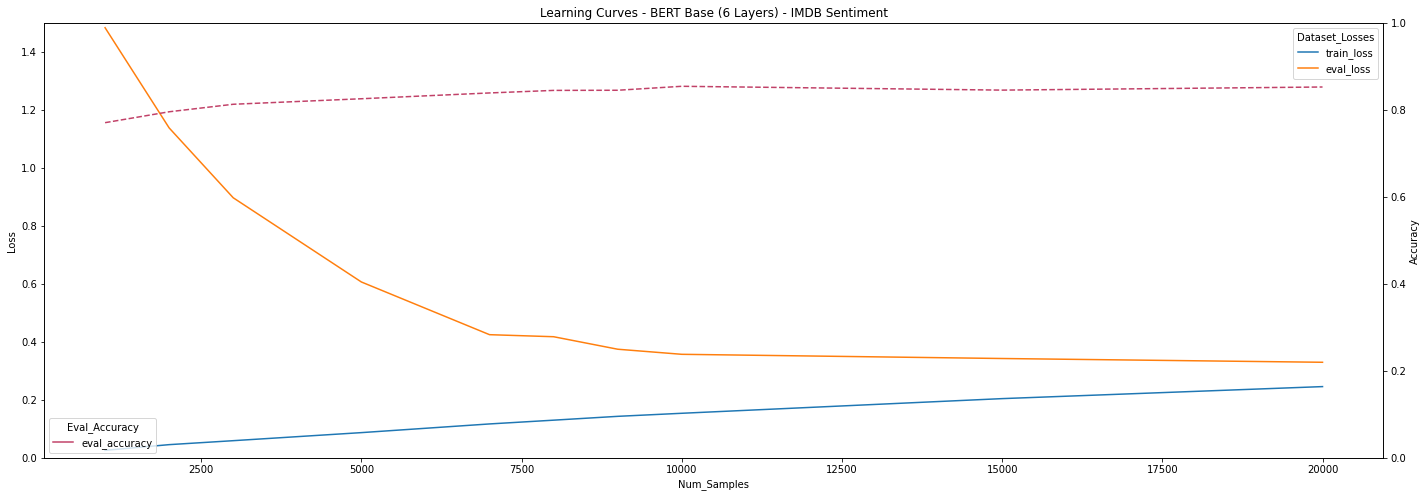

In [ ]:
plt.figure(figsize=(24, 8))
ax1 = sns.lineplot(x='Num_Samples', y='Loss', hue='Dataset_Losses', data=df_loss)
ax1.set_ylim(0, 1.5)

ax2 = plt.twinx()
sns.lineplot(x='Num_Samples', y='Accuracy', hue='Eval_Accuracy', data=df_accuracy, ax=ax2, palette="flare").set_title('Learning Curves - BERT Base (6 Layers) - IMDB Sentiment')
sns.move_legend(ax2, "lower left")
ax2.set_ylim(0, 1)
# Make one or more metric lines dashed
for line in ax2.lines:
    line.set_linestyle("--")